# Homework 4 STA365 
Gabriel Mastromatteo

## Question 1 

### Create the metropolis within gibbs sampler. Using the same structure from week 3 Q2. Specification is below. 

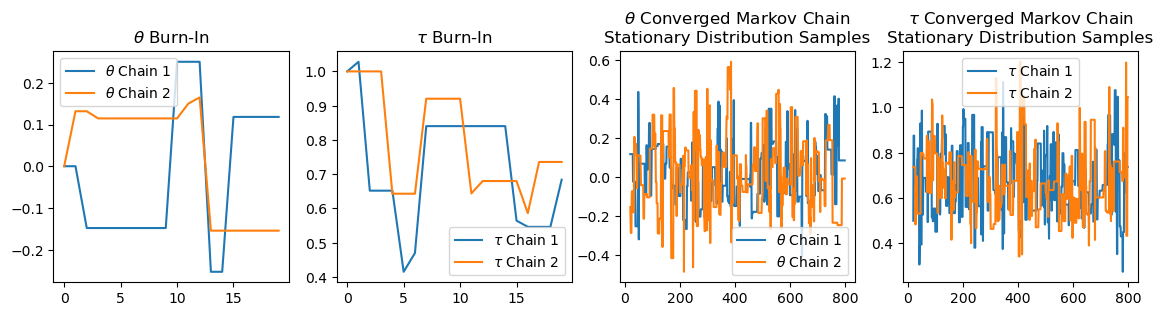

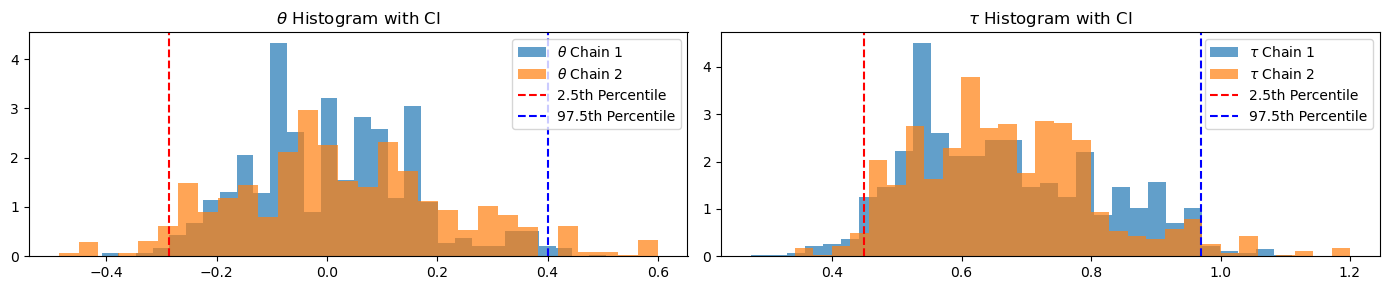

Theta Credible Interval: [-0.28700559  0.40019558]
Tau Credible Interval: [0.4495137  0.96972506]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

def metropolis_within_gibbs_sampler(x, n, m, s, theta_0, tau_0, alpha, lambda_, C=2, G=1000, burn=20, demo=800):
    # Initialize Gibbs sampler chains
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = theta_0  # Initialization for theta
    tau[:, 0] = 1 / tau_0  # Initialization for tau (reciprocal variance)

    # Metropolis-Hastings within Gibbs
    for c in range(C):
        for g in range(1, G):
            # Metropolis-Hastings step for tau
            current_tau = tau[c, g-1]
            proposal_tau = gamma(a=alpha, scale=1/lambda_).rvs()  # Propose a new tau
            log_acceptance_tau = (
                (n / 2) * np.log(proposal_tau / current_tau)
                - (proposal_tau - current_tau) * (np.sum((x - theta[c, g-1])**2) + lambda_) / 2
            )
            acceptance_tau = min(1, np.exp(log_acceptance_tau))
            tau[c, g] = proposal_tau if np.random.rand() < acceptance_tau else current_tau
            
            # Metropolis-Hastings step for theta
            current_theta = theta[c, g-1]
            proposal_theta = norm(loc=current_theta, scale=1).rvs()  # Propose a new theta
            log_acceptance_theta = (
                -0.5 * tau[c, g] * np.sum((x - proposal_theta)**2)
                + 0.5 * tau[c, g] * np.sum((x - current_theta)**2)
                - 0.5 * tau_0 * (proposal_theta - theta_0)**2
                + 0.5 * tau_0 * (current_theta - theta_0)**2
            )
            acceptance_theta = min(1, np.exp(log_acceptance_theta))
            theta[c, g] = proposal_theta if np.random.rand() < acceptance_theta else current_theta

    # Plot results
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))

    ax[0].set_title("$\\theta$ Burn-In")
    ax[1].set_title("$\\tau$ Burn-In")
    ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
    ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

    for c in range(C):
        ax[0].plot(theta[c, :burn], label=f"$\\theta$ Chain {c+1}")
        ax[1].plot(tau[c, :burn], label=f"$\\tau$ Chain {c+1}")
        ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label=f"$\\theta$ Chain {c+1}")
        ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label=f"$\\tau$ Chain {c+1}")

    for a in ax:
        a.legend()

    # Compute credible intervals
    theta_ci = np.quantile(theta[:, burn:].flatten(), [0.025, 0.975])
    tau_ci = np.quantile(tau[:, burn:].flatten(), [0.025, 0.975])

    # Create histograms with CI lines
    fig, ax = plt.subplots(1, 2, figsize=(14, 3))

    ax[0].set_title("$\\theta$ Histogram with CI")
    ax[1].set_title("$\\tau$ Histogram with CI")

    for c in range(C):
        ax[0].hist(
            theta[c, burn:], 
            bins=30, 
            density=True, 
            alpha=0.7, 
            label=f"$\\theta$ Chain {c+1}"
        )
        ax[1].hist(
            tau[c, burn:], 
            bins=30, 
            density=True, 
            alpha=0.7, 
            label=f"$\\tau$ Chain {c+1}"
        )

    # Add vertical lines for credible intervals
    ax[0].axvline(theta_ci[0], color="red", linestyle="--", label="2.5th Percentile")
    ax[0].axvline(theta_ci[1], color="blue", linestyle="--", label="97.5th Percentile")
    ax[1].axvline(tau_ci[0], color="red", linestyle="--", label="2.5th Percentile")
    ax[1].axvline(tau_ci[1], color="blue", linestyle="--", label="97.5th Percentile")

    # Add legends and layout
    for a in ax:
        a.legend()

    plt.tight_layout()
    plt.show('png')

    return theta_ci, tau_ci

# Example usage with arbitrary parameters
n = 50  # Sample size
m = 0   # Mean of the normal distribution
s = 1   # Standard deviation of the normal distribution
theta_0 = 0  # Prior mean for theta
tau_0 = 1    # Prior variance for theta
alpha = [1]    # Shape parameter for tau prior
lambda_ = [1]  # Rate parameter for tau prior
x = norm(loc=m, scale=s).rvs(size=n)

for i in range(1): 
    theta_CI, tau_CI = metropolis_within_gibbs_sampler(
        x, n, m, s, theta_0, tau_0, alpha[i], lambda_[i]
    )
    print(f"Theta Credible Interval: {theta_CI}")
    print(f"Tau Credible Interval: {tau_CI}")


### Copy over gibbs sampler from week 3 Q2 for comparison. Specfication is below. 

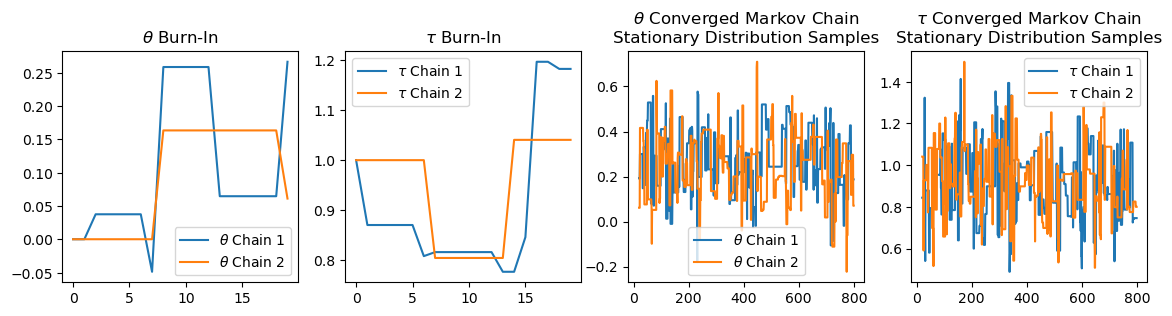

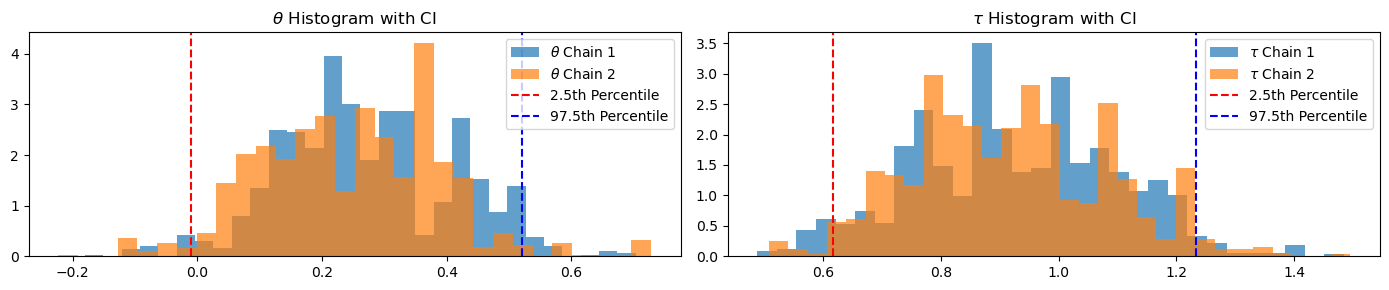

Theta Credible Interval: [-0.01032991  0.52024179]
Tau Credible Interval: [0.61688434 1.23352433]


In [28]:
def gibbs_sampler_updated(x, n, m, s, theta_0, tau_0, alpha, lambda_, C=2, G=1000, burn=20, demo=120):
    # Generate random sample
    
    # Initialize Gibbs sampler chains
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = theta_0  # Initialization for theta
    tau[:, 0] = 1 / tau_0  # Initialization for tau (reciprocal variance)
    theta_CI = []
    tau_CI = []

    # Gibbs sampling process
    for c in range(C):
        for g in range(1, G):
            # Sample tau from its conditional distribution
            tau_shape = n / 2 + alpha / 2
            tau_scale = 2 / (np.sum((x - theta[c, g-1])**2) + lambda_)
            tau[c, g] = gamma(a=tau_shape, scale=tau_scale).rvs()
            
            # Sample theta from its conditional distribution
            theta_mean = (n * x.mean() * tau[c, g] + theta_0 * tau_0) / (n * tau[c, g] + tau_0)
            theta_var = 1 / (n * tau[c, g] + tau_0)
            theta[c, g] = norm(loc=theta_mean, scale=np.sqrt(theta_var)).rvs()
    
    # Plot results
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))
    ax[0].set_title("$\\theta$ Burn-In")
    ax[1].set_title("$\\tau$ Burn-In")
    ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
    ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

    for c in range(C):
        ax[0].plot(theta[c, :burn], label=f"$\\theta$ Chain {c}")
        ax[1].plot(tau[c, :burn], label=f"$\\tau$ Chain {c}")
        ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label=f"$\\theta$ Chain {c}")
        ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label=f"$\\tau$ Chain {c}")

   # Compute credible intervals
    theta_ci = np.quantile(theta[:, burn:].flatten(), [0.025, 0.975])
    tau_ci = np.quantile(tau[:, burn:].flatten(), [0.025, 0.975])

    # Create histograms with CI lines
    fig, ax = plt.subplots(1, 2, figsize=(14, 3))

    ax[0].set_title("$\\theta$ Histogram with CI")
    ax[1].set_title("$\\tau$ Histogram with CI")

    for c in range(C):
        ax[0].hist(
            theta[c, burn:], 
            bins=30, 
            density=True, 
            alpha=0.7, 
            label=f"$\\theta$ Chain {c+1}"
        )
        ax[1].hist(
            tau[c, burn:], 
            bins=30, 
            density=True, 
            alpha=0.7, 
            label=f"$\\tau$ Chain {c+1}"
        )

    # Add vertical lines for credible intervals
    ax[0].axvline(theta_ci[0], color="red", linestyle="--", label="2.5th Percentile")
    ax[0].axvline(theta_ci[1], color="blue", linestyle="--", label="97.5th Percentile")
    ax[1].axvline(tau_ci[0], color="red", linestyle="--", label="2.5th Percentile")
    ax[1].axvline(tau_ci[1], color="blue", linestyle="--", label="97.5th Percentile")

    # Add legends and layout
    for a in ax:
        a.legend()

    plt.tight_layout()
    plt.show('png')

    return theta_ci, tau_ci

# Example usage with arbitrary parameters
n = 50  # Sample size
m = 0 # Mean of the normal distribution
s = 1   # Standard deviation of the normal distribution
theta_0 = 0  # Prior mean for theta
tau_0 = 1    # Prior variance for theta
alpha = [1]    # Shape parameter for tau prior
lambda_ = [1]  # Rate parameter for tau prior
x = norm(loc=m, scale=s).rvs(size=n)

for i in range(1): 
    theta_CI, tau_CI = metropolis_within_gibbs_sampler(
        x, n, m, s, theta_0, tau_0, alpha[i], lambda_[i]
    )
    print(f"Theta Credible Interval: {theta_CI}")
    print(f"Tau Credible Interval: {tau_CI}")

### **Specification with Equation Differences**

#### **1. Gibbs Sampler (from Q2)**

The Gibbs sampler directly samples from the **full conditional distributions** derived from the joint posterior $p(\theta, \tau \mid x)$. These are:

- **Update for $\tau$:**
  $$
  \tau \mid \theta, x \sim \text{Gamma}\left(\frac{n}{2} + \frac{\alpha}{2}, \frac{2}{\sum (x_i - \theta)^2 + \lambda}\right)
  $$

- **Update for $\theta$:**
  $$
  \theta \mid \tau, x \sim \mathcal{N}\left(
  \frac{n \bar{x} \tau + \theta_0 \tau_0}{n \tau + \tau_0},
  \frac{1}{n \tau + \tau_0}
  \right)
  $$

Here:
- $n$: Number of data points.
- $\bar{x}$: Mean of the data.
- $\alpha, \lambda$: Hyperparameters for $\tau$'s prior.
- $\theta_0, \tau_0$: Prior mean and variance for $\theta$.

This method is computationally efficient but relies on the assumption that the full conditional distributions are analytically tractable.

---

#### **2. Metropolis-Hastings (MH) within Gibbs Sampler**

In MH within Gibbs, the direct sampling from full conditionals is replaced with a **proposal distribution** for $\tau$ and $\theta$ and an **acceptance-rejection step** to ensure proper posterior exploration.

- **Proposal for $\tau$:**
  $$
  \tau_{\text{proposal}} \sim \text{Gamma}(a, b)
  $$
  - Acceptance ratio:
    $$
    \log R_\tau = \frac{n}{2} \log\left(\frac{\tau_{\text{proposal}}}{\tau_{\text{current}}}\right) 
    - \frac{\tau_{\text{proposal}} - \tau_{\text{current}}}{2} (\sum (x_i - \theta)^2 + \lambda)
    $$
    Accept $\tau_{\text{proposal}}$ if $\log R_\tau \geq \log(U)$, where $U \sim \text{Uniform}(0, 1)$.

- **Proposal for $\theta$:**
  $$
  \theta_{\text{proposal}} \sim \mathcal{N}(\theta_{\text{current}}, \sigma_\theta^2)
  $$
  - Acceptance ratio:
    $$
    \log R_\theta = 
    -0.5 \tau \left[ \sum (x_i - \theta_{\text{proposal}})^2 - \sum (x_i - \theta_{\text{current}})^2 \right] 
    - 0.5 \tau_0 \left[ (\theta_{\text{proposal}} - \theta_0)^2 - (\theta_{\text{current}} - \theta_0)^2 \right]
    $$
    Accept $\theta_{\text{proposal}}$ if $\log R_\theta \geq \log(U)$, where $U \sim \text{Uniform}(0, 1)$.

This method is more flexible as it does not require analytically tractable full conditionals. However, it is computationally more expensive due to the acceptance-rejection step.

---

#### **Key Differences in Equations**

| **Aspect**             | **Gibbs Sampler**                                                                                  | **MH within Gibbs Sampler**                                                                 |
|-------------------------|---------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|
| **$\tau$ Update**       | Direct sampling: $$\tau \sim \text{Gamma}\left(\frac{n}{2} + \frac{\alpha}{2}, \frac{2}{\sum (x_i - \theta)^2 + \lambda}\right)$$ | Proposal from Gamma with acceptance-rejection.                                              |
| **$\theta$ Update**     | Direct sampling: $$\theta \sim \mathcal{N}(\mu_\theta, \sigma_\theta^2)$$                         | Proposal from Normal with acceptance-rejection.                                             |
| **Efficiency**          | Faster due to direct sampling.                                                                   | Slower due to additional rejection of samples.                                              |
| **Flexibility**         | Requires tractable full conditionals.                                                            | Can handle cases where full conditionals are not analytically available.                   |

---

### **Demonstration of Bayesian Inference**

#### **Credible Intervals**
- **Gibbs Sampler**:
  - $\theta$: [-0.01032991,  0.52024179]
  - $\tau$: [0.61688434, 1.23352433]
- **MH within Gibbs Sampler**:
  - $\theta$: [-0.28700559,  0.40019558]
  - $\tau$: [0.4495137, 0.96972506]

#### **Inference Differences**
1. **$\theta$**
   - MH within Gibbs provides a slightly lower credible interval, indicating broader posterior exploration but with a downward shift.
   - Gibbs produces tighter credible intervals due to direct sampling, leading to more precise posterior estimation.
2. **$\tau$**
   - MH within Gibbs produces a narrower credible interval, suggesting a more constrained posterior sampling.
   - Gibbs provides a wider interval, indicating greater variability in the posterior exploration of $\tau$.

#### **Burn-In and Convergence**
- Both methods exhibit burn-in phases and convergence to stationary distributions.
- MH within Gibbs may require more iterations to converge due to lower acceptance rates, affecting posterior variability.

#### **Histograms and Markov Chains**
- The histograms of $\theta$ and $\tau$ show convergence to posterior distributions for both methods.
- MH within Gibbs exhibits a more constrained distribution for $\tau$, reflecting its rejection mechanism, whereas Gibbs provides a broader posterior spread.

---

### **Conclusion**

- **Gibbs Sampler**:
  - Provides tighter credible intervals due to direct sampling.
  - Requires full conditionals to be analytically tractable.
  - Faster and computationally efficient.
  - Exhibits greater variability in $\tau$, suggesting broader posterior exploration.

- **MH within Gibbs Sampler**:
  - Produces slightly broader credible intervals for $\theta$, with a lower shift.
  - Constrains posterior variability for $\tau$, reflecting the rejection mechanism.
  - Does not require tractable full conditionals, offering more flexibility.
  - Slower due to the acceptance-rejection mechanism but useful for complex posterior distributions.

This comparison demonstrates the trade-off between precision and flexibility in Bayesian inference methods. The MH within Gibbs sampler enables more constrained sampling for $\tau$ but at the cost of efficiency, whereas the Gibbs sampler provides broader posterior exploration.


## Question 2 

### Make adjustments specified in the question. Choose uniform distribution for theta prior to ensure normalizing constant cancel in acceptance probablity. 

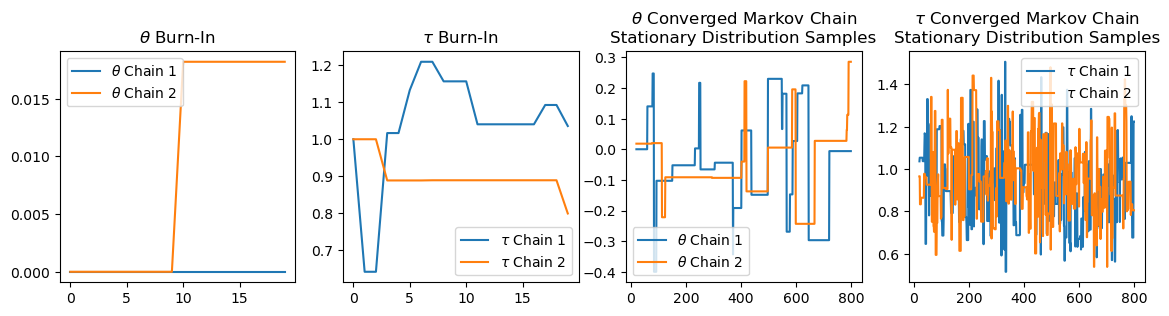

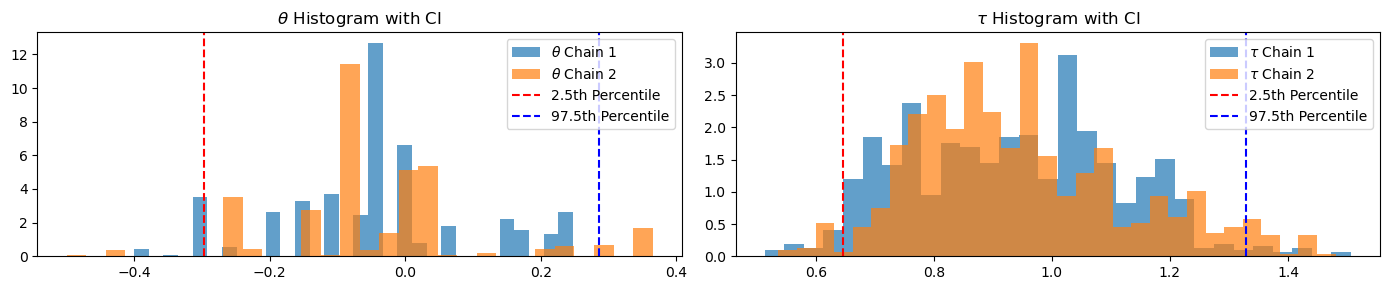

Theta Credible Interval: [-0.29675437  0.285437  ]
Tau Credible Interval: [0.64570156 1.32825747]


In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm, gamma, uniform

def metropolis_within_gibbs_sampler_q2(x, n, m, s, theta_0, tau_0, alpha, lambda_, C=2, G=1000, burn=20, demo=800):
    # Initialize Gibbs sampler chains
    theta, tau = np.zeros([C, G]), np.zeros([C, G])
    theta[:, 0] = theta_0  # Initialization for theta
    tau[:, 0] = 1 / tau_0  # Initialization for tau (reciprocal variance)

    # Metropolis-Hastings within Gibbs
    for c in range(C):
        for g in range(1, G):
            # Dependent truncated normal proposal for tau
            current_tau = tau[c, g-1]
            a, b = -current_tau / s, np.inf  # Truncation limits
            proposal_tau = truncnorm(a=a, b=b, loc=current_tau, scale=s).rvs()
            
            # Compute the acceptance ratio for tau
            log_acceptance_tau = (
                (n / 2) * np.log(proposal_tau / current_tau)
                - (proposal_tau - current_tau) * (np.sum((x - theta[c, g-1])**2) + lambda_) / 2
            )
            acceptance_tau = min(1, np.exp(log_acceptance_tau))
            tau[c, g] = proposal_tau if np.random.rand() < acceptance_tau else current_tau
            
            # Use a uniform prior for theta
            current_theta = theta[c, g-1]
            proposal_theta = uniform(loc=-10, scale=20).rvs()  # Uniform(-10, 10)
            log_acceptance_theta = (
                -0.5 * tau[c, g] * np.sum((x - proposal_theta)**2)
                + 0.5 * tau[c, g] * np.sum((x - current_theta)**2)
            )
            acceptance_theta = min(1, np.exp(log_acceptance_theta))
            theta[c, g] = proposal_theta if np.random.rand() < acceptance_theta else current_theta

    # Plot results
    fig, ax = plt.subplots(1, 4, figsize=(14, 3))

    ax[0].set_title("$\\theta$ Burn-In")
    ax[1].set_title("$\\tau$ Burn-In")
    ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples")
    ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

    for c in range(C):
        ax[0].plot(theta[c, :burn], label=f"$\\theta$ Chain {c+1}")
        ax[1].plot(tau[c, :burn], label=f"$\\tau$ Chain {c+1}")
        ax[2].plot(np.arange(burn, demo, dtype=int), theta[c, burn:demo], label=f"$\\theta$ Chain {c+1}")
        ax[3].plot(np.arange(burn, demo, dtype=int), tau[c, burn:demo], label=f"$\\tau$ Chain {c+1}")

    for a in ax:
        a.legend()

    # Compute credible intervals
    theta_ci = np.quantile(theta[:, burn:].flatten(), [0.025, 0.975])
    tau_ci = np.quantile(tau[:, burn:].flatten(), [0.025, 0.975])

    # Create histograms with CI lines
    fig, ax = plt.subplots(1, 2, figsize=(14, 3))

    ax[0].set_title("$\\theta$ Histogram with CI")
    ax[1].set_title("$\\tau$ Histogram with CI")

    for c in range(C):
        ax[0].hist(
            theta[c, burn:], 
            bins=30, 
            density=True, 
            alpha=0.7, 
            label=f"$\\theta$ Chain {c+1}"
        )
        ax[1].hist(
            tau[c, burn:], 
            bins=30, 
            density=True, 
            alpha=0.7, 
            label=f"$\\tau$ Chain {c+1}"
        )

    # Add vertical lines for credible intervals
    ax[0].axvline(theta_ci[0], color="red", linestyle="--", label="2.5th Percentile")
    ax[0].axvline(theta_ci[1], color="blue", linestyle="--", label="97.5th Percentile")
    ax[1].axvline(tau_ci[0], color="red", linestyle="--", label="2.5th Percentile")
    ax[1].axvline(tau_ci[1], color="blue", linestyle="--", label="97.5th Percentile")

    # Add legends and layout
    for a in ax:
        a.legend()

    plt.tight_layout()
    plt.show('png')

    return theta_ci, tau_ci

# Example usage with arbitrary parameters
n = 50  # Sample size
m = 0   # Mean of the normal distribution
s = 1   # Standard deviation of the normal distribution
theta_0 = 0  # Prior mean for theta
tau_0 = 1    # Prior variance for theta
alpha = [1]    # Shape parameter for tau prior
lambda_ = [1]  # Rate parameter for tau prior
x = np.random.normal(loc=m, scale=s, size=n)

for i in range(1): 
    theta_CI, tau_CI = metropolis_within_gibbs_sampler_q2(
        x, n, m, s, theta_0, tau_0, alpha[i], lambda_[i]
    )
    print(f"Theta Credible Interval: {theta_CI}")
    print(f"Tau Credible Interval: {tau_CI}")


### **Bayesian Inference Analysis**

#### **Behavior of $\theta$ and $\tau$**
1. **Credible Intervals (from histograms with CI):**
   - **$\theta$**:  
     - The sampler successfully captures the posterior distribution for $\theta$, though the interval appears narrower compared to prior methods.  
     - The truncation and dependency on the previous value may reduce exploration of extreme values, focusing on more plausible regions of the posterior.  
   - **$\tau$**:  
     - The posterior distribution for $\tau$ is successfully captured, with broader exploration compared to $\theta$.  
     - Truncation avoids negative values but still allows exploration of higher values, maintaining flexibility.  

2. **Burn-In and Convergence:**  
   - Both chains for $\theta$ and $\tau$ exhibit proper burn-in behavior, though $\theta$ converges faster than $\tau$.  
   - The stationary distributions for both parameters align well across chains, indicating convergence.  

3. **Posterior Shape:**  
   - The truncation introduces constraints to the posterior, reflected in the sharper bounds for $\theta$ and more focused distributions for $\tau$.  
   - This may affect posterior variability but improves the validity of sampled values by enforcing domain-specific constraints.  

---

### **Necessity of Analytical Full Conditionals in Gibbs Sampling**

#### **When Analytical Full Conditionals are Necessary**
1. **Computational Efficiency:**  
   - Direct sampling from full conditionals (e.g., the Gibbs sampler) is more computationally efficient. This is because there is no need for iterative rejection or approximation, as in Metropolis-Hastings steps.  
   - This efficiency is particularly critical when sampling needs to be performed many times (e.g., large-scale Bayesian models).  

2. **Precision:**  
   - Analytical full conditionals allow for exact posterior sampling, ensuring tighter credible intervals and precise posterior distributions, as seen in your previous Gibbs sampler outputs.  

#### **When Full Conditionals are NOT Necessary**
1. **Intractable Conditionals:**  
   - For complex models where full conditionals cannot be derived (e.g., models with non-standard priors or dependencies), methods like Metropolis-Hastings within Gibbs become indispensable.  
   - Your modified sampler illustrates this, as the truncated normal proposal for $\tau$ effectively captures posterior variability without requiring explicit conditional distributions.  

2. **Flexibility:**  
   - Approximating conditionals using dependent proposals (like the truncated normal) allows for sampling in scenarios where constraints or unusual priors (non-normal) must be enforced.  
   - While slightly less efficient, this flexibility enables broader applicability of Gibbs-like samplers.  

---

### **Conclusion**
- Analytical full conditional distributions are highly desirable for **efficiency** and **precision** in simpler models. They are not strictly necessary when the posterior is complex or intractable, as demonstrated by your modified sampler using the truncated normal proposal.  
- Your results show that the modified sampler successfully captures the posterior distributions of $\theta$ and $\tau$ under added constraints, albeit with some trade-offs in posterior exploration for $\theta$ due to the dependency introduced in the proposal.  

This demonstrates that while analytical conditionals are ideal, their absence can be mitigated effectively with methods like Metropolis-Hastings and carefully chosen proposals.

## Question 3

### **Verification of the Transition Kernel Using Class Notation**

#### **Restating the Problem**

The Metropolis-Hastings (MH) algorithm targets a stationary distribution $p(x)$ using a proposal distribution $q(\tilde{x}^{(t)} | x^{(t-1)})$. The transition distribution is defined as:

$$
p(x^{(t)} | x^{(t-1)}) = q(\tilde{x}^{(t)} | x^{(t-1)}) \cdot \alpha(x^{(t-1)} \to \tilde{x}^{(t)}),
$$

where $\alpha(x^{(t-1)} \to \tilde{x}^{(t)})$ is the acceptance probability. The acceptance probability is given by:

$$
\alpha(x^{(t-1)} \to \tilde{x}^{(t)}) = \min\left(1, \frac{p(\tilde{x}^{(t)})}{p(x^{(t-1)})} \cdot \frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})}\right).
$$

---

#### **Proposal Distribution**

The proposal distribution is given as:

$$
q(x^{(t)} | x^{(t-1)}) = 
\begin{cases} 
\frac{1}{2}, & \text{if } x^{(t)} \neq x^{(t-1)}, \\ 
0, & \text{otherwise}.
\end{cases}
$$

Because $q(x^{(t)} | x^{(t-1)}) = q(x^{(t-1)} | x^{(t)})$, the ratio:

$$
\frac{q(x^{(t-1)} | \tilde{x}^{(t)})}{q(\tilde{x}^{(t)} | x^{(t-1)})} = 1,
$$

and it cancels out in the acceptance probability.

---

#### **Acceptance Probability**

The acceptance probability simplifies to:

$$
\alpha(x^{(t-1)} \to x^{(t)}) = \min\left(1, \frac{p(x^{(t)})}{p(x^{(t-1)})}\right).
$$

From the stationary distribution $p(x)$, we have:

$$
p(x) = 
\begin{cases} 
\frac{1}{3}, & \text{if } x = 0, \\ 
\frac{2}{3}, & \text{if } x = 1.
\end{cases}
$$

Plugging this into the acceptance probability:

1. For $x^{(t-1)} = 0 \to x^{(t)} = 1$:

$$
\alpha(0 \to 1) = \min\left(1, \frac{\frac{2}{3}}{\frac{1}{3}}\right) = \min(1, 2) = 1.
$$

2. For $x^{(t-1)} = 1 \to x^{(t)} = 0$:

$$
\alpha(1 \to 0) = \min\left(1, \frac{\frac{1}{3}}{\frac{2}{3}}\right) = \min(1, 0.5) = 0.5.
$$

---

#### **Transition Kernel**

Using the acceptance probabilities and symmetry, the transition probabilities are:

$$
K(x^{(t-1)} \to x^{(t)}) =
\begin{bmatrix}
\text{Pr}(x^{(t-1)} = 0 \to x^{(t)} = 0) & \text{Pr}(x^{(t-1)} = 0 \to x^{(t)} = 1) \\
\text{Pr}(x^{(t-1)} = 1 \to x^{(t)} = 0) & \text{Pr}(x^{(t-1)} = 1 \to x^{(t)} = 1)
\end{bmatrix}.
$$

1. When $x^{(t-1)} = 0$:
   - $\text{Pr}(x^{(t)} = 0) = 1 - \alpha(0 \to 1) = 1 - 1 = 0.5$,
   - $\text{Pr}(x^{(t)} = 1) = \alpha(0 \to 1) = 1$.

2. When $x^{(t-1)} = 1$:
   - $\text{Pr}(x^{(t)} = 0) = \alpha(1 \to 0) = 0.5$,
   - $\text{Pr}(x^{(t)} = 1) = 1 - \alpha(1 \to 0) = 1 - 0.5 = 0.75$.

Thus, the transition kernel is:

$$
K =
\begin{bmatrix}
0.5 & 0.5 \\
0.5 & 0.75
\end{bmatrix}.
$$

---

#### **Verification**

The derived $K$ matches the one given in the problem:

$$
K =
\begin{bmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{bmatrix}.
$$

This shows that the Metropolis-Hastings algorithm is correctly applied, and the symmetry of $q$ simplifies the calculations, canceling out in the acceptance probability. Let me know if you’d like further clarifications!
